# Multivariate Time Series-based Solar Flare Prediction using SWAN-SF Dataset


TEAM MEMBERS: MohammadReza EskandariNasab, A02409763 (Graduate)

Dataset Name: Space Weather Analytics for Solar Flares (SWAN-SF)

Source of Data:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EBCFKM

The dataset is publicly available on the Harvard Dataverse platform, making it easily accessible for research and analysis.


The SWAN-SF dataset is a multivariate time series dataset designed for classifying solar flares into five categories: X, M, C, B, and FQ. It consists of five partitions, with a total volume exceeding 5 gigabytes, making it quite large in size. Each sample within the dataset has 24 unique attributes and a sequence length of 60, contributing to its high dimensionality. The current methodology for time series slicing in the SWAN-SF dataset involves using a sliding window with steps of 1 hour, where each slice has an observation period of 12 hours and a prediction span of 24 hours. Within this framework, each multivariate time series slice is assigned a category based on the most intense solar flare observed during its corresponding prediction window. For our analysis, we utilize only the first two partitions, which together comprise approximately 150,000 samples. However, this dataset presents significant challenges. These include class imbalance, multi-scaled attributes, missing values, and class overlap, all of which make achieving high classification performance particularly difficult. To simplify the task, we group the FQ, B, and C classes as “minor-flaring” and the M and X classes as “major-flaring,” transforming the classification task into a binary classification problem, distinguishing between minor- and major-flaring samples.

PROJECT OBJECTIVES:

The first step is to load the SWAN-SF dataset by iterating through each file, converting the data into pickle format. The dataset will then be split and saved into two files: one for the data and another for the binary labels associated with each sample. 

The next step involves applying various imputation and normalization techniques, including mean imputation, forward fill imputation, Min-Max scaling, and Z-score normalization, to assess their impact on improving solar flare classification accuracy using a GRU classifier.

Oversampling techniques such as SMOTE and ADASYN, along with random undersampling, will be incorporated to balance the dataset. The effect of these sampling methods on classification performance will be analyzed. 

In addition, statistical feature engineering and deep learning-based feature selection methods will be compared to determine which approach yields better classification accuracy. Several classifiers, including SVM, k-NN, GRU, and LSTM, will be used to evaluate which model performs best on the SWAN-SF dataset.

Box plots and bar charts will be used to visualize and assess the experimental results. The True Skill Statistic (TSS) will serve as the evaluation metric, as conventional metrics such as accuracy and F1-score are not appropriate for imbalanced datasets.

Descriptive statistics, data distribution analysis, and correlation analysis will be conducted to provide deeper insights into the dataset

## Loading the SWAN-SF Dataset

In [2]:
from pandas import DataFrame
from datetime import datetime
import os
from os import listdir
import pandas as pd
import numpy as np
import csv
import pickle
from tqdm import tqdm



class MVTSSample:
    
    def __init__(self, active_region:str, flare_class:str, flare_type:str, \
                 verification:str, start_time:datetime, end_time:datetime, data:DataFrame):
        self.flare_type = flare_type
        self.active_region = active_region
        self.flare_class = flare_class
        self.verification = verification
        self.start_time = start_time
        self.end_time = end_time
        self.data = data
    
    def get_flare_type(self):
        return self.flare_type
    
    def get_flare_class(self):
        return self.flare_class
    
    def get_active_region(self):
        return self.active_region
    
    def get_verification(self):
        return self.verification
    
    def get_start_time(self):
        return self.start_time
    
    def get_end_time(self):
        return self.end_time
    
    def get_data(self):
        return self.data
    
def read_mvts_instance(data_dir:str, file_name:str) -> MVTSSample:
    # Get flare type from file name
    if file_name[0:1] == 'F' :
        flare_type = file_name[0:2]
    else:
        flare_type = file_name[0:4]
    active_region = file_name[file_name.find('_ar')+3: file_name.find('_s2')]
    
    verification = 'FQ'
    flare_class = 'FQ'
    if file_name[0:1] != 'F' :
        verification = file_name.split(':')[1].split('_')[0]
        flare_class = file_name[0:1]
    

    try:
        # Get start time from file name
        start = file_name.find('s2')
        start_time = file_name[start+1: start+20]
        start_time = start_time.replace("T", " ")
        start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")

        # Get end time from file name
        end = file_name.find('e2')
        end_time = file_name[end+1: end+20]
        end_time = end_time.replace("T", " ")
        end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        print(ValueError)
        pass

    # Get data from csv file
    try:
        data = pd.read_csv(data_dir + "/" + file_name, sep="\t")
        data['Timestamp'] = data['Timestamp'].str.replace('-', '')
        data['Timestamp'] = data['Timestamp'].str.replace(' ', '')
        data['Timestamp'] = data['Timestamp'].str.replace(':', '')
    except ValueError:
        print(ValueError)
        pass
    
    # Make mvts object 
    mvts = MVTSSample(active_region, flare_class, flare_type, verification, start_time, end_time, data)
    return mvts


def process_partition(partition_location:str, data_dir_save:str, abt_name:str):
    abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']
    
    abt_header_label = ['FLARE_CLASS', 'FLARE_TYPE', 'ACTIVE_REGION', 'VERIFICATION']
    
    abt_label = pd.DataFrame(columns=abt_header_label)
    

    # Get lists of data from partition
    FL = os.listdir(partition_location + "/FL")
    NF = os.listdir(partition_location + "/NF")
    FN_NO_FQ = [i for i in NF if i[0:2]!='FQ']
    FN_FQ = [i for i in NF if i[0:2]=='FQ']
    
    Files = sorted(FL, reverse=True) + sorted(FN_NO_FQ, reverse=True) + FN_FQ
    
    number_of_features=25
    number_of_timestamps=60
    abt = np.zeros((number_of_timestamps,number_of_features,len(Files)))
    
    count = 0
    # Add row to abt from mvssample object and its median and std data
    with tqdm(len(Files)) as pbar:

        for d in Files:

            # Use temp list for each row and temp df
            list2add_label = []
            tempdf = pd.DataFrame(columns=abt_header)
            tempdf_label = pd.DataFrame(columns=abt_header_label)

            # Get mvs object and add flare type 
            if d in FL:
                mvs = read_mvts_instance(partition_location + '/FL', d)
            else:
                mvs = read_mvts_instance(partition_location + '/NF', d)
            list2add_label.append(mvs.get_flare_class())
            list2add_label.append(mvs.get_flare_type())
            list2add_label.append(mvs.get_active_region())
            list2add_label.append(mvs.get_verification())


            # Set up temp df for future concat with master data frame object
            templist = mvs.get_data()[abt_header]
            templist = templist.to_numpy()

            # From data frame concat current with temp for each feature 
            abt[:,:,count] = templist

            tempdf_label.loc[len(abt_header_label)] = list2add_label
            abt_label = pd.concat([abt_label, tempdf_label], ignore_index= True, axis = 0)


            count +=1
            pbar.update(1)
            

    print(abt_name)        
    print("shape: " + str(abt.shape))
    with open(data_dir_save + "1_Raw/" + abt_name + ".pkl", 'wb') as f:
        pickle.dump(abt, f)
        
    abt_label.to_csv(data_dir_save + "2_Labels/" + abt_name + "_Labels.csv", index=False, header=True)
    # return the completed analitics base table
    return abt_label



data_dir = "/Users/samskanderi/Documents/SWANSF/"  
data_dir_save = "/Users/samskanderi/Documents/SWANSF/Pickle/"  

# change the path to where your data is stored.

num_partitions = 5

for i in range(0,num_partitions):
    abt_name = "Partition" + str(i+1)
    abt = process_partition(data_dir + abt_name, data_dir_save, abt_name)
    print("number of instances: " + str(abt.shape[0]))
    print(abt.head(5))
    print('\n')

73492it [03:36, 339.77it/s]


Partition1
shape: (60, 25, 73492)
number of instances: 73492
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X6.9           753      Primary
1           X       X6.9           753      Primary
2           X       X6.9           753      Primary
3           X       X6.9           753      Primary
4           X       X6.9           753      Primary




88557it [04:39, 317.19it/s]


Partition2
shape: (60, 25, 88557)
number of instances: 88557
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X1.4          1834      Primary
1           X       X1.4          1834      Primary
2           X       X1.4          1834      Primary
3           X       X1.4          1834      Primary
4           X       X1.4          1834      Primary




42510it [01:56, 363.71it/s]


Partition3
shape: (60, 25, 42510)
number of instances: 42510
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X3.3          3341      Primary
1           X       X3.3          3341      Primary
2           X       X3.3          3341      Primary
3           X       X3.3          3341      Primary
4           X       X3.3          3341      Primary




51261it [02:25, 353.28it/s]


Partition4
shape: (60, 25, 51261)
number of instances: 51261
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X3.1          4698      Primary
1           X       X3.1          4698      Primary
2           X       X3.1          4698      Primary
3           X       X3.1          4698      Primary
4           X       X3.1          4698      Primary




75365it [03:48, 329.14it/s]


Partition5
shape: (60, 25, 75365)
number of instances: 75365
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X9.3          7115      Primary
1           X       X9.3          7115      Primary
2           X       X9.3          7115      Primary
3           X       X9.3          7115      Primary
4           X       X9.3          7115      Primary




# Missing Value Imputation and Normalization

### Missing value Exploration

In [3]:
# Loading the Raw Data
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/1_Raw/"
raw_data = []

num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + ".pkl", 'rb') as f:
        raw_data.append(pickle.load(f))
        
def print_missing_values(data, start_partition, end_partition):
    abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                               'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                                  'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']
    num_columns = 25
    num_timestamps = 60
    num_partitions = 5
    null_count = [0,0,0,0,0]
    non_null_count = [0,0,0,0,0]
    null_count_per_feature = np.zeros((num_partitions,num_columns), dtype=int)

    for i in range(start_partition-1, end_partition):
        partition = np.array(data[i])

        for j in range(0,partition.shape[2]):
            mvts = partition[:,:, j]
            for m in range(0,num_columns):
                for n in range (0,num_timestamps):
                    if (mvts[n,m] == 0.0 or mvts[n,m] == np.nan):
                        null_count[i] += 1
                        null_count_per_feature[i,m] += 1
                    else:
                        non_null_count[i] += 1

        print("Partition" + str(i+1) + ":\n")
        print("null counts in P" + str(i+1) + ": " + str(null_count[i]))
        print("non-null counts in P"+ str(i+1) + ": " + str(non_null_count[i]))
        for x in range(0,num_columns):
            print(abt_header[x] + ": " + str(null_count_per_feature[i,x]))

        print("\n")
        
print_missing_values(raw_data,1,5)

Partition1:

null counts in P1: 2487146
non-null counts in P1: 107750854
Timestamp: 0
R_VALUE: 2399220
TOTUSJH: 652
TOTBSQ: 652
TOTPOT: 652
TOTUSJZ: 652
ABSNJZH: 652
SAVNCPP: 652
USFLUX: 652
TOTFZ: 652
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 81406
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 652
MEANJZD: 0
MEANALP: 0
TOTFX: 652


Partition2:

null counts in P2: 4002503
non-null counts in P2: 128832997
Timestamp: 0
R_VALUE: 2934918
TOTUSJH: 93300
TOTBSQ: 93300
TOTPOT: 93300
TOTUSJZ: 93300
ABSNJZH: 93300
SAVNCPP: 93300
USFLUX: 93300
TOTFZ: 93300
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 134585
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 93300
MEANJZD: 0
MEANALP: 0
TOTFX: 93300


Partition3:

null counts in P3: 1472395
non-null counts in P3: 62292605
Timestamp: 0
R_VALUE: 1361095
TOTUSJH: 2718
TOTBSQ: 2718
TOTPOT: 2718
TOTUSJZ: 2718
ABSNJZH: 2718
SAVNCPP: 2725
USFLUX: 2718
TOTFZ: 2718
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR

In [8]:
data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/2_Labels/"
labels = []

num_partitions = 5

for i in range(0,num_partitions):
    labels.append(pd.read_csv(data_dir + "Partition" + str(i+1) + "_Labels.csv"))


def labels_pkl(start_partition, end_partition, data_dir, data, labels):
    category_mapping = {'X': 1, 'M': 1, 'B': 0, 'C': 0, 'FQ': 0}
    
    for i in range(start_partition-1,end_partition):
        
        the_labels = pd.DataFrame()
        the_labels['FLARE_CLASS'] = labels[i]['FLARE_CLASS'].map(category_mapping)
        new_partition_label = np.zeros(np.array(data[i]).shape[2])
        
        with tqdm(np.array(data[i]).shape[2]) as pbar:
            for j in range(0,np.array(data[i]).shape[2]):
                
                new_partition_label[j] = the_labels.iloc[j]
                
                pbar.update(1)
                

        Y_train = new_partition_label
    

        with open(data_dir + "Partition" + str(i+1) 
                       + "_Labels_Raw" + ".pkl", 'wb') as f:
            pickle.dump(Y_train, f)
            
        print("Partition" + str(i+1) + " is done.")
        

labels_pkl(1, 5, data_dir, raw_data, labels)

73492it [00:00, 93960.08it/s] 


Partition1 is done.


88557it [00:00, 97152.57it/s] 


Partition2 is done.


42510it [00:00, 97835.26it/s] 


Partition3 is done.


51261it [00:00, 97710.94it/s] 


Partition4 is done.


75365it [00:00, 96557.69it/s] 

Partition5 is done.


### Forward Fill Imputation Technique

In [9]:
import pandas as pd
import numpy as np

def next_or_previous_value_imputation(vector):
    # Convert the vector to a Pandas Series
    series = pd.Series(vector)
    
    # Perform next value imputation (backfill)
    next_imputed_series = series[::-1].fillna(method='ffill')[::-1]

    # Perform previous value imputation (forward fill) only for NaNs at the end
    previous_imputed_series = next_imputed_series.fillna(method='ffill')

    return previous_imputed_series

# Inter Column and Between Instance Imputation

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/3_Imputation/"

from tqdm import tqdm

k = 100
number_of_partitions = 5
for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(raw_data[i]).shape[2]))
    new_partition = np.array(raw_data[i])
    
    with tqdm(np.array(raw_data[i]).shape[2]) as pbar:
        for j in range(0,np.array(raw_data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = new_partition[:,:,j]
            new_column[new_column == 0.0] = np.nan
            for m in range(0,24):

                if np.isnan(new_column[:,m+1]).all():
                    new_column[:,m+1] = np.ones(60) 
                else:
                    new_column[:,m+1] = next_or_previous_value_imputation(new_column[:,m+1])
                 
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "Partition" + str(i+1) + "_FFImputation" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)
            
            
# Between Instance Imputation

73492it [01:58, 618.01it/s]
88557it [02:22, 620.47it/s]
42510it [01:08, 616.24it/s]
51261it [01:23, 612.93it/s]
75365it [02:02, 613.79it/s]


### Mean Imputation Technique

In [10]:
# Inter Column and Between Instance Imputation

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/3_Imputation/"

from tqdm import tqdm

number_of_partitions = 5
for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(raw_data[i]).shape[2]))
    new_partition = np.array(raw_data[i])
    
    with tqdm(np.array(raw_data[i]).shape[2]) as pbar:
        for j in range(0,np.array(raw_data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = new_partition[:,:,j]
            new_column[new_column == 0.0] = np.nan
            for m in range(0,24):

                if np.isnan(new_column[:,m+1]).all():
                    new_column[:,m+1] = np.ones(60) 
                else:
                    mean_non_zero = np.mean(new_column[:,m+1][~np.isnan(new_column[:,m+1])])
                    new_column[:,m+1][np.isnan(new_column[:,m+1])] = mean_non_zero
                 
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "Partition" + str(i+1) + "_MImputation" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)
            
            
# Between Instance Imputation

73492it [00:09, 8126.74it/s]
88557it [00:10, 8403.68it/s]
42510it [00:05, 8376.63it/s]
51261it [00:06, 8365.87it/s]
75365it [00:08, 8470.04it/s]


### Zscore Normalization Technique

In [1]:
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle

def zscore(start_partition, end_partition, data, labels, data_dir, name):
    """
    Applies Z-Score normalization to a 3D dataset after dropping the first feature,
    reshapes, shuffles, and saves the data and labels.

    Parameters:
    - start_partition: int, starting partition index (inclusive)
    - end_partition: int, ending partition index (exclusive)
    - data: list of 3D arrays, each element with shape (num_timestamps, num_features, num_samples)
    - labels: list of corresponding labels for each partition
    - data_dir: str, directory to save the output files
    - name: str, suffix name for the output files
    """

    for i in range(start_partition - 1, end_partition):
        # Access the current partition data
        partition_data = np.array(data[i])  # Shape: (num_timestamps, num_features, num_samples)
        partition_labels = np.array(labels[i])  # Corresponding labels

        # Drop the first feature (index 0)
        partition_data = partition_data[:, 1:, :]  # Shape becomes (num_timestamps, 24, num_samples)

        # Transpose to shape (num_samples, num_timestamps, num_features) for easier normalization
        partition_data = partition_data.transpose(2, 0, 1)  # Shape: (num_samples, num_timestamps, num_features)

        num_samples, num_timestamps, num_features = partition_data.shape

        # Initialize new array for normalized data
        normalized_partition = np.zeros_like(partition_data)

        # Apply Z-Score normalization for each feature independently
        with tqdm(range(num_features), desc=f"Processing Partition {i+1}") as pbar:
            for j in range(num_features):
                # Extract all data for feature j across samples and timestamps
                feature_data = partition_data[:, :, j].flatten()  # Flatten into 1D array

                # Compute Z-Score normalization
                if np.std(feature_data) == 0.0:
                    zscore = np.ones_like(feature_data)
                else:
                    zscore = stats.zscore(feature_data)

                if np.isnan(zscore).any() or np.isinf(zscore).any():
                    print(f"nan or inf found in Z-score for feature {j} in partition {i+1}")

                # Reshape and assign back to the normalized partition
                normalized_partition[:, :, j] = zscore.reshape(num_samples, num_timestamps)
                pbar.update(1)

        # Shuffle the normalized data and labels
        indices = np.arange(normalized_partition.shape[0])
        np.random.shuffle(indices)
        normalized_partition = normalized_partition[indices]
        partition_labels = partition_labels[indices]

        # Save the shuffled and normalized data and corresponding labels
        with open(f"{data_dir}Partition{i+1}_{name}.pkl", 'wb') as f:
            pickle.dump(normalized_partition, f)
        with open(f"{data_dir}Partition{i+1}_Labels_{name}.pkl", 'wb') as f:
            pickle.dump(partition_labels, f)

### MinMax Normalization Technique

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pickle

def minmax(start_partition, end_partition, data, labels, data_dir, name):
    """
    Applies Min-Max Scaling to a 3D dataset after dropping the first feature,
    reshapes, shuffles, and saves the data and labels.

    Parameters:
    - start_partition: int, starting partition index (inclusive)
    - end_partition: int, ending partition index (exclusive)
    - data: list of 3D arrays, each element with shape (num_timestamps, num_features, num_samples)
    - labels: list of corresponding labels for each partition
    - data_dir: str, directory to save the output files
    - name: str, suffix name for the output files
    """

    for i in range(start_partition - 1, end_partition):
        # Access the current partition data
        partition_data = np.array(data[i])  # Shape: (num_timestamps, num_features, num_samples)
        partition_labels = np.array(labels[i])  # Corresponding labels

        # Drop the first feature (index 0)
        partition_data = partition_data[:, 1:, :]  # Shape becomes (num_timestamps, 24, num_samples)

        # Transpose to shape (num_samples, num_timestamps, num_features) for easier normalization
        partition_data = partition_data.transpose(2, 0, 1)  # Shape: (num_samples, num_timestamps, num_features)

        num_samples, num_timestamps, num_features = partition_data.shape

        # Initialize new array for scaled data
        scaled_partition = np.zeros_like(partition_data)

        # Apply Min-Max Scaling for each feature independently
        with tqdm(range(num_features), desc=f"Processing Partition {i+1}") as pbar:
            for j in range(num_features):
                # Extract all data for feature j across samples and timestamps
                feature_data = partition_data[:, :, j].reshape(-1, 1)  # Reshape to 2D for scaler

                # Apply Min-Max Scaling
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled_data = scaler.fit_transform(feature_data)

                # Reshape and assign back to the scaled partition
                scaled_partition[:, :, j] = scaled_data.reshape(num_samples, num_timestamps)
                pbar.update(1)

        # Shuffle the scaled data and labels
        indices = np.arange(scaled_partition.shape[0])
        np.random.shuffle(indices)
        scaled_partition = scaled_partition[indices]
        partition_labels = partition_labels[indices]

        # Save the shuffled and scaled data and corresponding labels
        with open(f"{data_dir}Partition{i+1}_{name}.pkl", 'wb') as f:
            pickle.dump(scaled_partition, f)
        with open(f"{data_dir}Partition{i+1}_Labels_{name}.pkl", 'wb') as f:
            pickle.dump(partition_labels, f)

#### Reading the Data (Mean Imputation)

In [3]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/3_Imputation/"

imputed_data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_MImputation" +".pkl", 'rb') as f:
        imputed_data.append(pickle.load(f))
        
    print("P"+str(i+1)+" Nan-Value: "+ str(np.isnan(imputed_data[i]).any() or np.isinf(imputed_data[i]).any()))  

    with open(data_dir + "Partition" + str(i+1) + "_Labels_Raw" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

P1 Nan-Value: False
P2 Nan-Value: False
P3 Nan-Value: False
P4 Nan-Value: False
P5 Nan-Value: False


In [4]:
data_dir = "/Users/samskanderi/Documents/SWANSF/pickle/4_Normalization/"
name = 'ZNorm_MImputation'

zscore(1,5,imputed_data,labels, data_dir, name)

Processing Partition 5: 100%|███████████████████| 24/24 [00:00<00:00, 25.81it/s]


In [5]:
data_dir = "/Users/samskanderi/Documents/SWANSF/pickle/4_Normalization/"
name = 'MMNorm_MImputation'

minmax(1,5,imputed_data,labels, data_dir, name)

Processing Partition 5: 100%|███████████████████| 24/24 [00:00<00:00, 47.41it/s]


#### Reading the Data (Forward Fill Imputation)

In [6]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/3_Imputation/"

imputed_data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_FFImputation" +".pkl", 'rb') as f:
        imputed_data.append(pickle.load(f))
        
    print("P"+str(i+1)+" Nan-Value: "+ str(np.isnan(imputed_data[i]).any() or np.isinf(imputed_data[i]).any()))  

    with open(data_dir + "Partition" + str(i+1) + "_Labels_Raw" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

P1 Nan-Value: False
P2 Nan-Value: False
P3 Nan-Value: False
P4 Nan-Value: False
P5 Nan-Value: False


In [7]:
data_dir = "/Users/samskanderi/Documents/SWANSF/pickle/4_Normalization/"
name = 'ZNorm_FFImputation'

zscore(1,5,imputed_data,labels, data_dir, name)

Processing Partition 5: 100%|███████████████████| 24/24 [00:00<00:00, 24.24it/s]


In [8]:
data_dir = "/Users/samskanderi/Documents/SWANSF/pickle/4_Normalization/"
name = 'MMNorm_FFImputation'

minmax(1,5,imputed_data,labels, data_dir, name)

Processing Partition 5: 100%|███████████████████| 24/24 [00:00<00:00, 47.83it/s]


### Classification using GRU

In [1]:
def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


# GRU

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix

def gru_model(X_train, Y_train, X_test, Y_test):
        
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features = 60, 24
    
    model = Sequential()
    model.add(GRU(units=120, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.SpecificityAtSensitivity(sensitivity=0.95))

    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    y_pred = model.predict(X_test)
    threshold = 0.5  # Adjust the threshold as needed
    y_pred_binary = (y_pred > threshold).astype(int)
    
    print(str(X_train.shape)+': GRU Classifier is Done! \n')


    confusion = confusion_matrix(Y_test, y_pred_binary)
    tn, fp, fn, tp = confusion.ravel()

    tss = TSS(tp,tn,fp,fn)
    
    output_values = np.array([tp, fn, fp, tn, tss])

    
    return output_values

def save_results(reslut, name):
    data_dir = "/Users/samskanderi/Documents/SWANSF/results/"

    with open(data_dir + name + ".pkl", 'wb') as f:
        pickle.dump(reslut, f)

#### Reading the Data (Mean Imputation and Zscore Normalization)

In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/4_Normalization/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [3]:
gru_concat = kfold_training('GRU', data, labels, gru_model, 4)
save_results(gru_concat, "GRU_ZNorm_MImputation")

2768/2768 [==============================] - 14s 5ms/step
(73492, 60, 24): GRU Classifier is Done! 

1329/1329 [==============================] - 7s 5ms/step
(88557, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 8s 5ms/step
(42510, 60, 24): GRU Classifier is Done! 

2356/2356 [==============================] - 12s 5ms/step
(51261, 60, 24): GRU Classifier is Done! 



#### Reading the Data (Forward Fill Imputation and Zscore Normalization)

In [4]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/4_Normalization/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_ZNorm_FFImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_ZNorm_FFImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [5]:
gru_concat = kfold_training('GRU', data, labels, gru_model, 4)
save_results(gru_concat, "GRU_ZNorm_FFImputation")

2768/2768 [==============================] - 14s 5ms/step
(73492, 60, 24): GRU Classifier is Done! 

1329/1329 [==============================] - 6s 5ms/step
(88557, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 7s 5ms/step
(42510, 60, 24): GRU Classifier is Done! 

2356/2356 [==============================] - 11s 5ms/step
(51261, 60, 24): GRU Classifier is Done! 



#### Reading the Data (Mean Imputation and MinMax Normalization)

In [6]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/4_Normalization/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_MMNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_MMNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [7]:
gru_concat = kfold_training('GRU', data, labels, gru_model, 4)
save_results(gru_concat, "GRU_MMNorm_MImputation")

2768/2768 [==============================] - 13s 5ms/step
(73492, 60, 24): GRU Classifier is Done! 

2768/2768 [==============================] - 13s 5ms/step
(73492, 60, 24): GRU Classifier is Done! 

1329/1329 [==============================] - 7s 5ms/step
(88557, 60, 24): GRU Classifier is Done! 

1329/1329 [==============================] - 6s 5ms/step
(88557, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 8s 5ms/step
(42510, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 8s 5ms/step
(42510, 60, 24): GRU Classifier is Done! 

2356/2356 [==============================] - 12s 5ms/step
(51261, 60, 24): GRU Classifier is Done! 



#### Reading the Data (Forward Fill Imputation and MinMax Normalization)

In [4]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/4_Normalization/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_MMNorm_FFImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_MMNorm_FFImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [9]:
gru_concat = kfold_training('GRU', data, labels, gru_model, 4)
save_results(gru_concat, "GRU_MMNorm_FFImputation")

2768/2768 [==============================] - 13s 5ms/step
(73492, 60, 24): GRU Classifier is Done! 

1329/1329 [==============================] - 6s 4ms/step
(88557, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 11s 7ms/step
(42510, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 10s 6ms/step
(42510, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 9s 6ms/step
(42510, 60, 24): GRU Classifier is Done! 

1602/1602 [==============================] - 10s 6ms/step
(42510, 60, 24): GRU Classifier is Done! 

2356/2356 [==============================] - 15s 6ms/step
(51261, 60, 24): GRU Classifier is Done! 



### Visualization

In [4]:
import seaborn as sns
import pickle
import numpy as np
sns.set_style("darkgrid")

data_dir = "/Users/samskanderi/Documents/SWANSF/results/"
model_name = ['GRU']
pre_name = ['ZNorm_MImputation', 'ZNorm_FFImputation', 'MMNorm_MImputation', 'MMNorm_FFImputation']


values = np.zeros((4,4))
count = 0
for name in model_name:
    for s_name in pre_name:
        with open(data_dir + name + '_' + s_name + ".pkl", 'rb') as f:
            values[count,:] = [arr[6] for arr in pickle.load(f)]
            count += 1


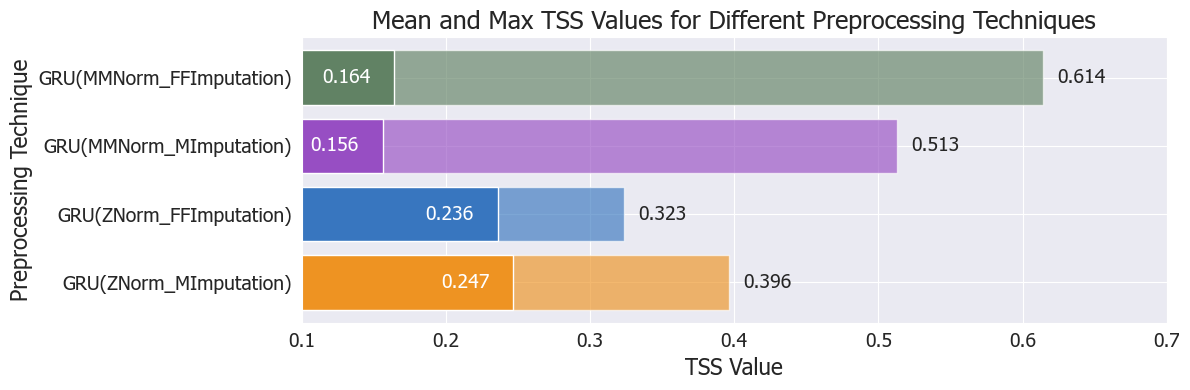

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# Use seaborn style

# Adjust font settings for better readability
font = {'family': 'Tahoma', 'weight': 'normal', 'size': 10}
plt.rc('font', **font)

# Models and sampling techniques
models = ['GRU']
sampling = ['ZNorm_MImputation', 'ZNorm_FFImputation', 'MMNorm_MImputation', 'MMNorm_FFImputation']

tss_values_mean = [np.mean(values[i, :]) for i in range(4)]
tss_values_std = [np.std(values[i, :]) for i in range(4)]
tss_values_max = [np.max(values[i, :]) for i in range(4)]



# Generate labels for each bar
labels = [f'{model}({samp})' for model in models for samp in sampling]

fig, ax = plt.subplots(figsize=(12, 4))

# Define improved colors for the groups
colors = ['#EE9322', '#3876BF', '#974EC3', '#618264']


bars = plt.barh(labels[0:1], tss_values_max[0:1], color=colors[0], alpha = 0.65)
bars += plt.barh(labels[1:2], tss_values_max[1:2], color=colors[1], alpha = 0.65)
bars += plt.barh(labels[2:3], tss_values_max[2:3], color=colors[2], alpha = 0.65)
bars += plt.barh(labels[3:4], tss_values_max[3:4], color=colors[3], alpha = 0.65)

# Add TSS values on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center', fontsize=14)
    

    # Create bars with specific colors
bars = plt.barh(labels[0:1], tss_values_mean[0:1], color=colors[0])
bars += plt.barh(labels[1:2], tss_values_mean[1:2], color=colors[1])
bars += plt.barh(labels[2:3], tss_values_mean[2:3], color=colors[2])
bars += plt.barh(labels[3:4], tss_values_mean[3:4], color=colors[3])

# Add TSS values on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width - 0.05
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center', color = 'white', fontsize=14 )



# Set labels and title
plt.xlabel('TSS Value', fontsize=16)
plt.ylabel('Preprocessing Technique', fontsize=16)
plt.title('Mean and Max TSS Values for Different Preprocessing Techniques', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlim(.1, .7)  # Adjust the x-axis limit


plt.tight_layout()
plt.savefig('Preprocessing.png')


# Show the plot
plt.show()


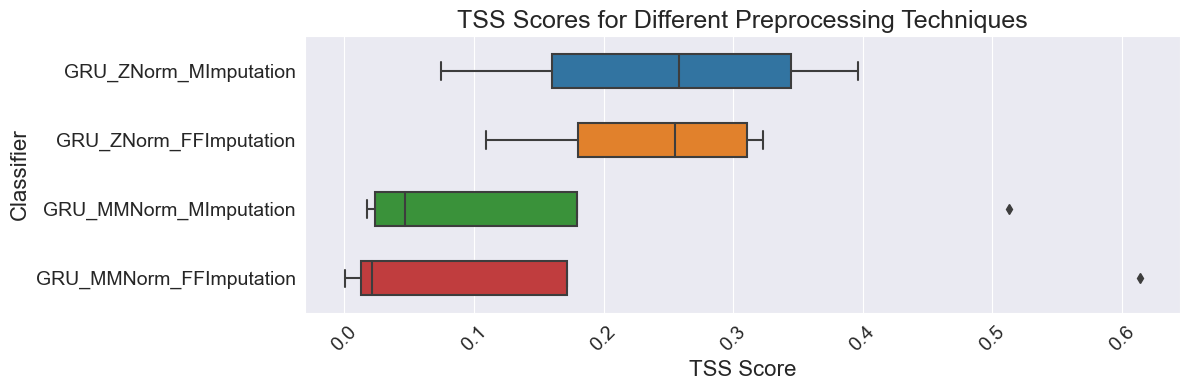

In [29]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths and classifier names
data_dir = "/Users/samskanderi/Documents/SWANSF/results/"
all_model_names = ['GRU']
sampling_names = ['ZNorm_MImputation', 'ZNorm_FFImputation', 'MMNorm_MImputation', 'MMNorm_FFImputation']
# Prepare a list to collect all TSS scores and model labels
tss_scores = []
models = []

# Function to generate file name based on model, sampling technique, and special naming conditions
def get_file_name(model, sampling):
    return f"{model}_{sampling}.pkl"
 

# Loop over each model and sampling technique
for model in all_model_names:
    for sampling in sampling_names:
        file_name = get_file_name(model, sampling)
        file_path = data_dir + file_name
        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                for entry in data:
                    tss_scores.append(entry[6])  # Assuming the 7th element is the TSS score
                    models.append(f"{model}_{sampling}")
        except FileNotFoundError as e:
            print(f"Error opening file {file_path}: {e}")

# Create DataFrame for plotting
df = pd.DataFrame({'Model': models, 'TSS': tss_scores})

# Plotting
sns.set_style("darkgrid")
plt.figure(figsize=(12, 4))
sns.boxplot(y='Model', x='TSS', data=df, width=0.5)  # Swapped x and y axis

# Set explicit font sizes
title_fontsize = 18  # Increase base size by 25%
xlabel_fontsize = 16 # Increase base size by 50%
xticks_fontsize = 14  # Increase base size by 50%

plt.title('TSS Scores for Different Preprocessing Techniques', fontsize=title_fontsize)
plt.xlabel('TSS Score', fontsize=xlabel_fontsize)
plt.ylabel('Classifier', fontsize=xlabel_fontsize)
plt.xticks(rotation=45, fontsize=xticks_fontsize)
plt.yticks(fontsize=xticks_fontsize)


plt.tight_layout()
plt.savefig('preprocessing_box.png')

plt.show()

## Sampling Techniques

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.decomposition import PCA



def tsne_visualization(minority, minority_generated, name, partition_num):

    sns.set_style("darkgrid")

    # Combine all data into one dataset
    combined_data = np.concatenate((minority, minority_generated))

    # Create labels for the data
    labels = np.array(['Original'] * len(minority) + ['Synthetic'] * len(minority_generated))

    # Perform t-SNE
    tsne = TSNE(n_components=2,learning_rate='auto', init='random', perplexity=40)
    tsne_results = tsne.fit_transform(combined_data)

    # Plotting
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1], 
        hue=labels, 
        palette=['red', 'blue'],
        alpha=0.2,
        s=15
    )
    
    plt.title('t-SNE plot of SWAN-SF Dataset (Partition '+str(partition_num)+') with ' + name, fontsize=10)


    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    
    plt.savefig(name+'_tsne_p'+str(partition_num)+'.pdf')

    plt.legend(loc='best')
    plt.show()


def pca_visualization(minority, minority_generated, name, partition_num):
    sns.set_style("darkgrid")

    # Combine all data into one dataset
    combined_data = np.concatenate((minority, minority_generated))

    # Create labels for the data
    labels = np.array(['Original'] * len(minority) + ['Synthetic'] * len(minority_generated))

    # Perform PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(combined_data)

    # Plotting
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=pca_results[:, 0], y=pca_results[:, 1], 
        hue=labels, 
        palette=['red', 'blue'],
        alpha=0.2,
        s=15
    )

    plt.title('PCA plot of SWAN-SF Dataset (Partition '+str(partition_num)+') with ' + name, fontsize=10)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    
    plt.savefig(name+'_pca_p'+str(partition_num)+'.pdf')

    plt.legend(loc='best')
    plt.show()


### SMOTE and ADASYN

In [51]:
import numpy as np
import pickle
from imblearn.over_sampling import SMOTE, ADASYN

def smote_adasyn(start_position, end_position, data_dir, name, X_train, Y_train):
    """
    Applies SMOTE and ADASYN to imbalanced 3D data by first converting to 2D,
    performing sampling, then converting back to 3D.

    Parameters:
    - start_position: int, starting partition index (inclusive)
    - end_position: int, ending partition index (exclusive)
    - data_dir: str, directory to save the output files
    - name: str, suffix name for the output files
    - X_train: list of 3D arrays, each with shape (num_samples, num_timestamps, num_features)
    - Y_train: list of 1D arrays, labels corresponding to each partition
    """

    for i in range(start_position - 1, end_position):
        # Convert 3D to 2D for sampling
        partition_data = X_train[i].reshape(X_train[i].shape[0], -1)  # Shape: (num_samples, num_timestamps * num_features)
        partition_labels = Y_train[i]  # Shape: (num_samples,)

        # Downsample class 0 and concatenate with class 1
        num_nf_to_keep = 10000  # Number of class 0 samples to keep
        class_0_indices = np.where(partition_labels == 0)[0]
        class_1_indices = np.where(partition_labels == 1)[0]
        selected_class_0_indices = np.random.choice(class_0_indices, size=num_nf_to_keep, replace=False)
        new_indices = np.concatenate((selected_class_0_indices, class_1_indices))
        partition_data_rus = partition_data[new_indices]
        partition_labels_rus = partition_labels[new_indices]

        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority', random_state=42)
        data_smote, labels_smote = smote.fit_resample(partition_data_rus, partition_labels_rus)

        # Apply ADASYN
        adasyn = ADASYN(sampling_strategy='minority', random_state=42)
        data_adasyn, labels_adasyn = adasyn.fit_resample(partition_data_rus, partition_labels_rus)

        # Reshape back to 3D
        num_timestamps, num_features = X_train[i].shape[1], X_train[i].shape[2]
        data_smote_3d = data_smote.reshape(-1, num_timestamps, num_features)  # Shape: (num_samples, num_timestamps, num_features)
        data_adasyn_3d = data_adasyn.reshape(-1, num_timestamps, num_features)  # Shape: (num_samples, num_timestamps, num_features)

        # Shuffle data and labels for SMOTE
        num_samples_smote = data_smote_3d.shape[0]
        shuffle_indices_smote = np.random.permutation(num_samples_smote)
        data_smote_shuffled = data_smote_3d[shuffle_indices_smote]
        labels_smote_shuffled = labels_smote[shuffle_indices_smote]

        # Shuffle data and labels for ADASYN
        num_samples_adasyn = data_adasyn_3d.shape[0]
        shuffle_indices_adasyn = np.random.permutation(num_samples_adasyn)
        data_adasyn_shuffled = data_adasyn_3d[shuffle_indices_adasyn]
        labels_adasyn_shuffled = labels_adasyn[shuffle_indices_adasyn]
        
        print('Partition' + str(i+1) + ': ')
        print(data_smote_shuffled.shape)
        print(str(data_adasyn_shuffled.shape)+ '\n')

        # Save SMOTE output
        with open(f"{data_dir}RUS_Smote_Partition{i+1}_{name}.pkl", 'wb') as f:
            pickle.dump(data_smote_shuffled, f)
        with open(f"{data_dir}RUS_Smote_Partition{i+1}_Labels_{name}.pkl", 'wb') as f:
            pickle.dump(labels_smote_shuffled, f)

        # Save ADASYN output
        with open(f"{data_dir}RUS_Adasyn_Partition{i+1}_{name}.pkl", 'wb') as f:
            pickle.dump(data_adasyn_shuffled, f)
        with open(f"{data_dir}RUS_Adasyn_Partition{i+1}_Labels_{name}.pkl", 'wb') as f:
            pickle.dump(labels_adasyn_shuffled, f)

#### Reading the Data (Mean Imputation and Zscore Normalization)

In [52]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/4_Normalization/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [53]:
data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/5_Sampling/"

name = "ZNorm_MImputation"

smote_adasyn(1, 5, data_dir, name, data, labels)

Partition1: 
(20000, 60, 24)
(19990, 60, 24)

Partition2: 
(20000, 60, 24)
(19972, 60, 24)

Partition3: 
(20000, 60, 24)
(19978, 60, 24)

Partition4: 
(20000, 60, 24)
(20040, 60, 24)

Partition5: 
(20000, 60, 24)
(20012, 60, 24)



### Classification using GRU

In [1]:
def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


# GRU

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix

def gru_model(X_train, Y_train, X_test, Y_test):
        
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features = 60, 24
    
    model = Sequential()
    model.add(GRU(units=120, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.SpecificityAtSensitivity(sensitivity=0.95))

    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    y_pred = model.predict(X_test)
    threshold = 0.5  # Adjust the threshold as needed
    y_pred_binary = (y_pred > threshold).astype(int)
    
    print(str(X_train.shape)+': GRU Classifier is Done! \n')


    confusion = confusion_matrix(Y_test, y_pred_binary)
    tn, fp, fn, tp = confusion.ravel()

    tss = TSS(tp,tn,fp,fn)
    
    output_values = np.array([tp, fn, fp, tn, tss])

    
    return output_values

def save_results(reslut, name):
    data_dir = "/Users/samskanderi/Documents/SWANSF/results/"

    with open(data_dir + name + ".pkl", 'wb') as f:
        pickle.dump(reslut, f)

#### Reading the Data (Mean Imputation, Zscore Normalization, and SMOTE Sampling)

In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/5_Sampling/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "RUS_SMOTE" + "_Partition" + str(i+1) + "_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "RUS_SMOTE" + "_Partition" + str(i+1) + "_Labels_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [3]:
gru_concat = kfold_training('GRU', data, labels, gru_model, 4)
save_results(gru_concat, "GRU_SMOTE_ZNorm_MImputation")

625/625 [==============================] - 3s 4ms/step
(20000, 60, 24): GRU Classifier is Done! 

625/625 [==============================] - 3s 5ms/step
(20000, 60, 24): GRU Classifier is Done! 

625/625 [==============================] - 3s 5ms/step
(20000, 60, 24): GRU Classifier is Done! 

625/625 [==============================] - 3s 5ms/step
(20000, 60, 24): GRU Classifier is Done! 



#### Reading the Data (Mean Imputation, Zscore Normalization, and ADASYN Sampling)

In [4]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/5_Sampling/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "RUS_ADASYN" + "_Partition" + str(i+1) + "_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "RUS_ADASYN" + "_Partition" + str(i+1) + "_Labels_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [5]:
gru_concat = kfold_training('GRU', data, labels, gru_model, 4)
save_results(gru_concat, "GRU_ADASYN_ZNorm_MImputation")

625/625 [==============================] - 3s 5ms/step
(19990, 60, 24): GRU Classifier is Done! 

625/625 [==============================] - 3s 5ms/step
(19972, 60, 24): GRU Classifier is Done! 

627/627 [==============================] - 3s 5ms/step
(19978, 60, 24): GRU Classifier is Done! 

626/626 [==============================] - 3s 5ms/step
(20040, 60, 24): GRU Classifier is Done! 



### Visualization

In [8]:
import seaborn as sns
import numpy as np
import pickle
sns.set_style("darkgrid")

data_dir = "/Users/samskanderi/Documents/SWANSF/results/"
model_name = ['GRU']
pre_name = ['ZNorm_MImputation', 'SMOTE_ZNorm_MImputation', 'ADASYN_ZNorm_MImputation']


values = np.zeros((3,4))
count = 0
for name in model_name:
    for s_name in pre_name:
        with open(data_dir + name + '_' + s_name + ".pkl", 'rb') as f:
            values[count,:] = [arr[6] for arr in pickle.load(f)]
            count += 1


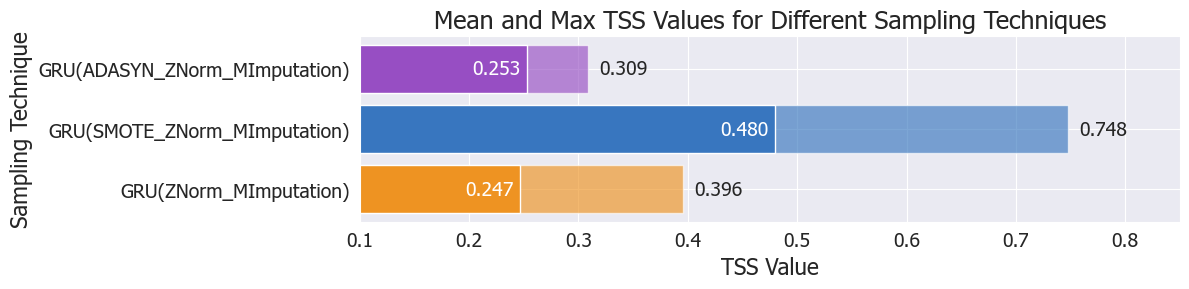

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# Use seaborn style

# Adjust font settings for better readability
font = {'family': 'Tahoma', 'weight': 'normal', 'size': 10}
plt.rc('font', **font)

# Models and sampling techniques
models = ['GRU']
sampling = ['ZNorm_MImputation', 'SMOTE_ZNorm_MImputation', 'ADASYN_ZNorm_MImputation']

tss_values_mean = [np.mean(values[i, :]) for i in range(3)]
tss_values_std = [np.std(values[i, :]) for i in range(3)]
tss_values_max = [np.max(values[i, :]) for i in range(3)]



# Generate labels for each bar
labels = [f'{model}({samp})' for model in models for samp in sampling]

fig, ax = plt.subplots(figsize=(12, 3))

# Define improved colors for the groups
colors = ['#EE9322', '#3876BF', '#974EC3']


bars = plt.barh(labels[0:1], tss_values_max[0:1], color=colors[0], alpha = 0.65)
bars += plt.barh(labels[1:2], tss_values_max[1:2], color=colors[1], alpha = 0.65)
bars += plt.barh(labels[2:3], tss_values_max[2:3], color=colors[2], alpha = 0.65)

# Add TSS values on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center', fontsize=14)
    

    # Create bars with specific colors
bars = plt.barh(labels[0:1], tss_values_mean[0:1], color=colors[0])
bars += plt.barh(labels[1:2], tss_values_mean[1:2], color=colors[1])
bars += plt.barh(labels[2:3], tss_values_mean[2:3], color=colors[2])

# Add TSS values on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width - 0.05
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center', color = 'white', fontsize=14 )



# Set labels and title
plt.xlabel('TSS Value', fontsize=16)
plt.ylabel('Sampling Technique', fontsize=16)
plt.title('Mean and Max TSS Values for Different Sampling Techniques', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlim(.1, .85)  # Adjust the x-axis limit


plt.tight_layout()
plt.savefig('sampling.png')


# Show the plot
plt.show()


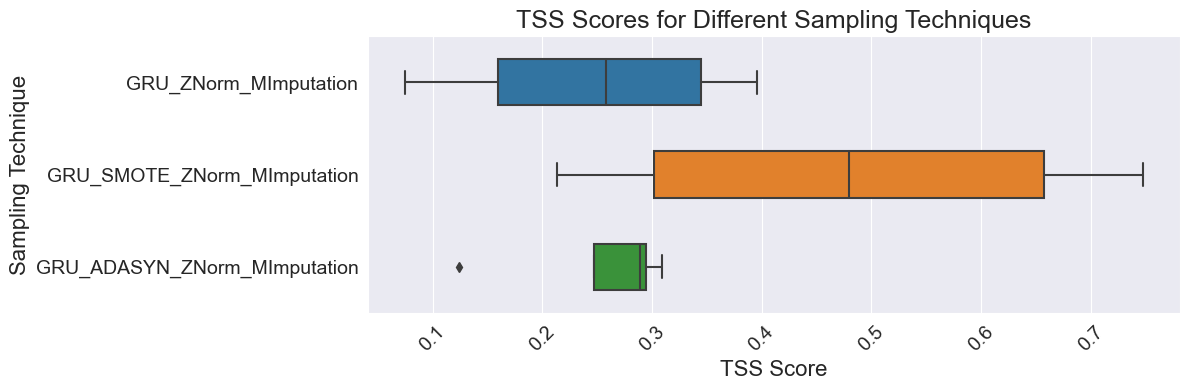

In [10]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths and classifier names
data_dir = "/Users/samskanderi/Documents/SWANSF/results/"
all_model_names = ['GRU']
sampling_names = ['ZNorm_MImputation', 'SMOTE_ZNorm_MImputation', 'ADASYN_ZNorm_MImputation']
# Prepare a list to collect all TSS scores and model labels
tss_scores = []
models = []

# Function to generate file name based on model, sampling technique, and special naming conditions
def get_file_name(model, sampling):
    return f"{model}_{sampling}.pkl"
 

# Loop over each model and sampling technique
for model in all_model_names:
    for sampling in sampling_names:
        file_name = get_file_name(model, sampling)
        file_path = data_dir + file_name
        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                for entry in data:
                    tss_scores.append(entry[6])  # Assuming the 7th element is the TSS score
                    models.append(f"{model}_{sampling}")
        except FileNotFoundError as e:
            print(f"Error opening file {file_path}: {e}")

# Create DataFrame for plotting
df = pd.DataFrame({'Model': models, 'TSS': tss_scores})

# Plotting
sns.set_style("darkgrid")
plt.figure(figsize=(12, 4))
sns.boxplot(y='Model', x='TSS', data=df, width=0.5)  # Swapped x and y axis

# Set explicit font sizes
title_fontsize = 18  # Increase base size by 25%
xlabel_fontsize = 16 # Increase base size by 50%
xticks_fontsize = 14  # Increase base size by 50%

plt.title('TSS Scores for Different Sampling Techniques', fontsize=title_fontsize)
plt.xlabel('TSS Score', fontsize=xlabel_fontsize)
plt.ylabel('Sampling Technique', fontsize=xlabel_fontsize)
plt.xticks(rotation=45, fontsize=xticks_fontsize)
plt.yticks(fontsize=xticks_fontsize)


plt.tight_layout()
plt.savefig('sampling_box.png')

plt.show()

## Feature Engineering and Selection Analysis

### Statistical Feature Engineering

In [7]:
import numpy as np
import pickle
from scipy.stats import skew, kurtosis

def feature_engineering(data_dir, name, X_train, Y_train):
    """
    Computes statistical properties (mean, std, max, min, skewness, kurtosis, median)
    for each feature and saves the transformed 2D dataset.

    Parameters:
    - data_dir: str, directory to save the output files
    - name: str, suffix name for the output files
    - X_train: list of 3D arrays, each with shape (num_samples, num_timestamps, num_features)
    - Y_train: list of 1D arrays, labels corresponding to each partition
    """
    for i, partition_data in enumerate(X_train):
        num_samples, num_timestamps, num_features = partition_data.shape
        features_stat = np.zeros((num_samples, num_features * 7))  # 7 stats per feature

        for j in range(num_features):
            # Compute stats for each feature
            features_stat[:, j * 7 + 0] = np.mean(partition_data[:, :, j], axis=1)
            features_stat[:, j * 7 + 1] = np.std(partition_data[:, :, j], axis=1)
            features_stat[:, j * 7 + 2] = np.max(partition_data[:, :, j], axis=1)
            features_stat[:, j * 7 + 3] = np.min(partition_data[:, :, j], axis=1)
            features_stat[:, j * 7 + 4] = skew(partition_data[:, :, j], axis=1)
            features_stat[:, j * 7 + 5] = kurtosis(partition_data[:, :, j], axis=1)
            features_stat[:, j * 7 + 6] = np.median(partition_data[:, :, j], axis=1)
            
        print(f"Partition{i+1} is done. Shape:{features_stat.shape}")

        # Save transformed data
        with open(f"{data_dir}Partition{i+1}_{name}.pkl", 'wb') as f:
            pickle.dump(features_stat, f)
        with open(f"{data_dir}Partition{i+1}_Labels_{name}.pkl", 'wb') as f:
            pickle.dump(Y_train[i], f)

#### Reading the Data (Mean Imputation, Zscore Normalization, and SMOTE Sampling)

In [8]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/5_Sampling/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "RUS_SMOTE" + "_Partition" + str(i+1) + "_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "RUS_SMOTE" + "_Partition" + str(i+1) + "_Labels_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [9]:
data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/6_Feature/"

name = "Stat_SMOTE_ZNorm_MImputation"

feature_engineering(data_dir, name, data, labels)

/var/folders/fx/gjhbmrbj5jn295_9wrqpbsv80000gn/T/ipykernel_5039/334481669.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features_stat[:, j * 7 + 4] = skew(partition_data[:, :, j], axis=1)
/var/folders/fx/gjhbmrbj5jn295_9wrqpbsv80000gn/T/ipykernel_5039/334481669.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features_stat[:, j * 7 + 5] = kurtosis(partition_data[:, :, j], axis=1)


Partition1 is done. Shape:(20000, 168)
Partition2 is done. Shape:(20000, 168)
Partition3 is done. Shape:(20000, 168)
Partition4 is done. Shape:(20000, 168)
Partition5 is done. Shape:(20000, 168)


### Deep Learning-based Feature Selection

In [13]:
import numpy as np
import pickle

def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


# GRU

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix

def gru_model(X_train, Y_train, X_test, Y_test):
        
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features = 60, 1
    
    model = Sequential()
    model.add(GRU(units=16, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.SpecificityAtSensitivity(sensitivity=0.95))

    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    y_pred = model.predict(X_test)
    threshold = 0.5  # Adjust the threshold as needed
    y_pred_binary = (y_pred > threshold).astype(int)
    
    print(str(X_train.shape)+': GRU Classifier is Done! \n')


    confusion = confusion_matrix(Y_test, y_pred_binary)
    tn, fp, fn, tp = confusion.ravel()

    tss = TSS(tp,tn,fp,fn)
    
    output_values = np.array([tp, fn, fp, tn, tss])

    
    return output_values




def attribute_selection_gru_tss(data_dir, name, X_train, Y_train):
    """
    Train GRU for each attribute independently, compute TSS, select top 6 attributes,
    and save the dataset with only selected attributes.

    Parameters:
    - data_dir: str, directory to save the output files
    - name: str, suffix name for the output files
    - X_train: list of 3D arrays, each with shape (num_samples, num_timestamps, num_features)
    - Y_train: list of 1D arrays, labels corresponding to each partition
    """

    # Number of attributes
    num_features = X_train[0].shape[2]
    tss_scores = []

    for j in range(num_features):
        print(f"Processing Attribute {j+1}/{num_features}...")

        # Prepare data for single attribute
        X_train_single = [partition[:, :, j:j+1] for partition in X_train]  # Select one attribute

        # Compute TSS using k-fold training
        metrics = kfold_training(
            name, 
            X_train_single, 
            Y_train, 
            gru_model, 
            num=4  # 4 folds for k-fold cross-validation
        )

        # Average TSS over folds
        average_tss = np.mean([metric[-1] for metric in metrics])
        tss_scores.append((j, average_tss))

    # Select top 6 attributes based on TSS
    tss_scores.sort(key=lambda x: x[1], reverse=True)
    top_attributes = [x[0] for x in tss_scores[:6]]

    print(f"Top 6 attributes based on TSS: {top_attributes}")

    # Save dataset with only top 6 attributes
    for i, partition_data in enumerate(X_train):
        reduced_data = partition_data[:, :, top_attributes]  # Select only the top 6 attributes
        with open(f"{data_dir}Partition{i+1}_{name}.pkl", 'wb') as f:
            pickle.dump(reduced_data, f)
        with open(f"{data_dir}Partition{i+1}_Labels_{name}.pkl", 'wb') as f:
            pickle.dump(Y_train[i], f)

    print("Top attributes dataset saved.")

In [14]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/5_Sampling/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "RUS_SMOTE" + "_Partition" + str(i+1) + "_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "RUS_SMOTE" + "_Partition" + str(i+1) + "_Labels_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [15]:
data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/6_Feature/"

name = "DLSelection_SMOTE_ZNorm_MImputation"

attribute_selection_gru_tss(data_dir, name, data, labels)

Processing Attribute 1/24...
625/625 [==============================] - 1s 960us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 946us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 933us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 958us/step
(20000, 60, 1): GRU Classifier is Done! 

Processing Attribute 2/24...
625/625 [==============================] - 1s 947us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 948us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 950us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 947us/step
(20000, 60, 1): GRU Classifier is Done! 

Processing Attribute 3/24...
625/625 [==============================] - 1s 963us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [=============

625/625 [==============================] - 1s 944us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 953us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 954us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 953us/step
(20000, 60, 1): GRU Classifier is Done! 

Processing Attribute 19/24...
625/625 [==============================] - 1s 961us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 948us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 956us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 948us/step
(20000, 60, 1): GRU Classifier is Done! 

Processing Attribute 20/24...
625/625 [==============================] - 1s 960us/step
(20000, 60, 1): GRU Classifier is Done! 

625/625 [==============================] - 1s 944

### Classification

#### Statistical Feature Engineering on SVM

In [9]:
import numpy as np
import pickle

def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
import numpy as np

def svm_model(X_train, Y_train, X_test, Y_test, n_neighbors=5):
    """
    Train and evaluate an SVM classifier with KNN imputation for missing values.

    Parameters:
    - X_train: ndarray, training features
    - Y_train: ndarray, training labels
    - X_test: ndarray, test features
    - Y_test: ndarray, test labels
    - n_neighbors: int, number of neighbors for KNN imputation (default: 5)
    """
    # Apply KNN Imputation to handle missing values
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    X_train_imputed = knn_imputer.fit_transform(X_train)
    X_test_imputed = knn_imputer.transform(X_test)

    # Create an SVM classifier (with RBF kernel by default)
    svm_classifier = SVC(kernel='rbf', C=1.0)
    svm_classifier.fit(X_train_imputed, Y_train)
    y_pred = svm_classifier.predict(X_test_imputed)

    print(str(X_train.shape) + ': SVM Classifier with KNN Imputation is Done! \n')

    # Compute confusion matrix
    confusion = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = confusion.ravel()

    # Compute TSS
    tss = TSS(tp, tn, fp, fn)

    output_values = np.array([tp, fn, fp, tn, tss])

    return output_values

def save_results(reslut, name):
    data_dir = "/Users/samskanderi/Documents/SWANSF/results/"

    with open(data_dir + name + ".pkl", 'wb') as f:
        pickle.dump(reslut, f)

In [10]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/6_Feature/"

data = []
labels = []

num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_Stat_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_Stat_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [11]:
gru_concat = kfold_training('SVM', data, labels, svm_model, 4)
save_results(gru_concat, "SVM_Stat_SMOTE_ZNorm_MImputation")

(20000, 168): SVM Classifier with KNN Imputation is Done! 

(20000, 168): SVM Classifier with KNN Imputation is Done! 

(20000, 168): SVM Classifier with KNN Imputation is Done! 

(20000, 168): SVM Classifier with KNN Imputation is Done! 



#### Statistical Feature Engineering on K-NN

In [15]:
import numpy as np
import pickle

def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix

def knn_model(X_train, Y_train, X_test, Y_test, n_neighbors=5, imputation_neighbors=5):
    """
    Train and evaluate a KNN classifier with KNN imputation for missing values.

    Parameters:
    - X_train: ndarray, training features
    - Y_train: ndarray, training labels
    - X_test: ndarray, test features
    - Y_test: ndarray, test labels
    - n_neighbors: int, number of neighbors for KNN classification (default: 5)
    - imputation_neighbors: int, number of neighbors for KNN imputation (default: 5)

    Returns:
    - output_values: ndarray, containing various evaluation metrics
    """
    # Apply KNN Imputation to handle missing values
    knn_imputer = KNNImputer(n_neighbors=imputation_neighbors)
    X_train_imputed = knn_imputer.fit_transform(X_train)
    X_test_imputed = knn_imputer.transform(X_test)

    # Create a KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train_imputed, Y_train)
    y_pred = knn_classifier.predict(X_test_imputed)

    print(f"{X_train.shape}: KNN Classifier with KNN Imputation is Done!\n")

    # Compute confusion matrix
    confusion = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = confusion.ravel()

    # Compute metrics
    tss = TSS(tp, tn, fp, fn)

    output_values = np.array([tp, fn, fp, tn, tss])

    return output_values

In [16]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/6_Feature/"

data = []
labels = []

num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_Stat_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_Stat_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [17]:
gru_concat = kfold_training('KNN', data, labels, knn_model, 4)
save_results(gru_concat, "KNN_Stat_SMOTE_ZNorm_MImputation")

(20000, 168): KNN Classifier with KNN Imputation is Done!

(20000, 168): KNN Classifier with KNN Imputation is Done!

(20000, 168): KNN Classifier with KNN Imputation is Done!

(20000, 168): KNN Classifier with KNN Imputation is Done!



#### Deep Learning-based Feature Selection on GRU

In [18]:
import numpy as np
import pickle

def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


# GRU

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix

def gru_model(X_train, Y_train, X_test, Y_test):
        
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features = 60, 6
    
    model = Sequential()
    model.add(GRU(units=64, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.SpecificityAtSensitivity(sensitivity=0.95))

    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    y_pred = model.predict(X_test)
    threshold = 0.5  # Adjust the threshold as needed
    y_pred_binary = (y_pred > threshold).astype(int)
    
    print(str(X_train.shape)+': GRU Classifier is Done! \n')


    confusion = confusion_matrix(Y_test, y_pred_binary)
    tn, fp, fn, tp = confusion.ravel()

    tss = TSS(tp,tn,fp,fn)
    
    output_values = np.array([tp, fn, fp, tn, tss])

    
    return output_values

def save_results(reslut, name):
    data_dir = "/Users/samskanderi/Documents/SWANSF/results/"

    with open(data_dir + name + ".pkl", 'wb') as f:
        pickle.dump(reslut, f)

In [19]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/6_Feature/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_DLSelection_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_DLSelection_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [20]:
gru_concat = kfold_training('GRU', data, labels, gru_model, 4)
save_results(gru_concat, "GRU_DLSelection_SMOTE_ZNorm_MImputation")

625/625 [==============================] - 1s 2ms/step
(20000, 60, 6): GRU Classifier is Done! 

625/625 [==============================] - 1s 2ms/step
(20000, 60, 6): GRU Classifier is Done! 

625/625 [==============================] - 1s 2ms/step
(20000, 60, 6): GRU Classifier is Done! 

625/625 [==============================] - 1s 2ms/step
(20000, 60, 6): GRU Classifier is Done! 



#### Deep Learning-based Feature Selection on GRU

In [1]:
import numpy as np
import pickle

def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


# LSTM

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix

def lstm_model(X_train, Y_train, X_test, Y_test):
    
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features = 60, 6

    model = Sequential()
    model.add(LSTM(64, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.SpecificityAtSensitivity(sensitivity=0.95))
    
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    y_pred = model.predict(X_test)
    threshold = 0.5  # Adjust the threshold as needed
    y_pred_binary = (y_pred > threshold).astype(int)
    
    print(str(X_train.shape)+': LSTM Classifier is Done! \n')


    confusion = confusion_matrix(Y_test, y_pred_binary)
    tn, fp, fn, tp = confusion.ravel()

    tss = TSS(tp,tn,fp,fn)
    
    output_values = np.array([tp, fn, fp, tn, tss])
    
    return output_values


def save_results(reslut, name):
    data_dir = "/Users/samskanderi/Documents/SWANSF/results/"

    with open(data_dir + name + ".pkl", 'wb') as f:
        pickle.dump(reslut, f)

In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/6_Feature/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_DLSelection_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_DLSelection_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [3]:
gru_concat = kfold_training('LSTM', data, labels, lstm_model, 4)
save_results(gru_concat, "LSTM_DLSelection_SMOTE_ZNorm_MImputation")

625/625 [==============================] - 2s 2ms/step
(20000, 60, 6): LSTM Classifier is Done! 

625/625 [==============================] - 2s 2ms/step
(20000, 60, 6): LSTM Classifier is Done! 

625/625 [==============================] - 2s 2ms/step
(20000, 60, 6): LSTM Classifier is Done! 

625/625 [==============================] - 2s 2ms/step
(20000, 60, 6): LSTM Classifier is Done! 



#### No Feature Engineering on LSTM

In [5]:
import numpy as np
import pickle

def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def kfold_training(name, X_train, Y_train, training_func, num):
    kfold = np.array([[1,2],[2,3],[3,4],[4,5]])

    metrics = []
    metrics_values = np.array([])
    
    for i in range(0, num):
        train_index = kfold[i,0]
        test_index = kfold[i,1]
        metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        while (metrics_values[0]==0):
            metrics_values = training_func(X_train[train_index-1], Y_train[train_index-1], X_train[test_index-1], Y_train[test_index-1])
        
        metrics.append(np.append(np.append(train_index, test_index), metrics_values))
    return metrics


# LSTM

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix

def lstm_model(X_train, Y_train, X_test, Y_test):
        
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features = 60, 24

    model = Sequential()
    model.add(LSTM(120, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.SpecificityAtSensitivity(sensitivity=0.95))
    
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    y_pred = model.predict(X_test)
    threshold = 0.5  # Adjust the threshold as needed
    y_pred_binary = (y_pred > threshold).astype(int)
    
    print(str(X_train.shape)+': LSTM Classifier is Done! \n')


    confusion = confusion_matrix(Y_test, y_pred_binary)
    tn, fp, fn, tp = confusion.ravel()

    tss = TSS(tp,tn,fp,fn)
    
    output_values = np.array([tp, fn, fp, tn, tss])
    
    return output_values


def save_results(reslut, name):
    data_dir = "/Users/samskanderi/Documents/SWANSF/results/"

    with open(data_dir + name + ".pkl", 'wb') as f:
        pickle.dump(reslut, f)

In [7]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/5_Sampling/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "RUS_SMOTE_" + "Partition" + str(i+1) + "_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "RUS_SMOTE_" + "Partition" + str(i+1) + "_Labels_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))

In [8]:
gru_concat = kfold_training('LSTM', data, labels, lstm_model, 4)
save_results(gru_concat, "LSTM_SMOTE_ZNorm_MImputation")

625/625 [==============================] - 4s 6ms/step
(20000, 60, 24): LSTM Classifier is Done! 

625/625 [==============================] - 4s 6ms/step
(20000, 60, 24): LSTM Classifier is Done! 

625/625 [==============================] - 4s 6ms/step
(20000, 60, 24): LSTM Classifier is Done! 

625/625 [==============================] - 4s 6ms/step
(20000, 60, 24): LSTM Classifier is Done! 



### Visualization

In [3]:
import seaborn as sns
import pickle
import numpy as np
sns.set_style("darkgrid")

data_dir = "/Users/samskanderi/Documents/SWANSF/results/"
model_name = ['LSTM_SMOTE_ZNorm_MImputation', 'GRU_SMOTE_ZNorm_MImputation', 'LSTM_DLSelection_SMOTE_ZNorm_MImputation',
             'GRU_DLSelection_SMOTE_ZNorm_MImputation', 'SVM_Stat_SMOTE_ZNorm_MImputation', 'KNN_Stat_SMOTE_ZNorm_MImputation']


values = np.zeros((6,4))
count = 0
for name in model_name:
    with open(data_dir + name + ".pkl", 'rb') as f:
        values[count,:] = [arr[6] for arr in pickle.load(f)]
        count += 1


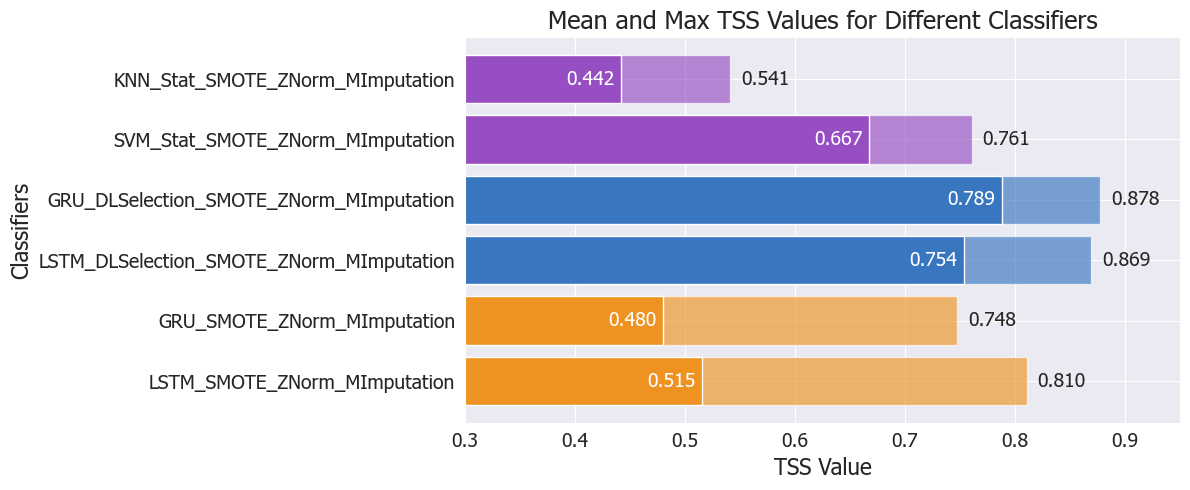

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# Use seaborn style

# Adjust font settings for better readability
font = {'family': 'Tahoma', 'weight': 'normal', 'size': 10}
plt.rc('font', **font)

# Models and sampling techniques
model_name = ['LSTM_SMOTE_ZNorm_MImputation', 'GRU_SMOTE_ZNorm_MImputation', 'LSTM_DLSelection_SMOTE_ZNorm_MImputation',
             'GRU_DLSelection_SMOTE_ZNorm_MImputation', 'SVM_Stat_SMOTE_ZNorm_MImputation', 'KNN_Stat_SMOTE_ZNorm_MImputation']

tss_values_mean = [np.mean(values[i, :]) for i in range(6)]
tss_values_std = [np.std(values[i, :]) for i in range(6)]
tss_values_max = [np.max(values[i, :]) for i in range(6)]



# Generate labels for each bar
labels = model_name

fig, ax = plt.subplots(figsize=(12, 5))

# Define improved colors for the groups
colors = ['#EE9322', '#EE9322', '#3876BF', '#3876BF', '#974EC3', '#974EC3']


bars = plt.barh(labels[0:1], tss_values_max[0:1], color=colors[0], alpha = 0.65)
bars += plt.barh(labels[1:2], tss_values_max[1:2], color=colors[1], alpha = 0.65)
bars += plt.barh(labels[2:3], tss_values_max[2:3], color=colors[2], alpha = 0.65)
bars += plt.barh(labels[3:4], tss_values_max[3:4], color=colors[3], alpha = 0.65)
bars += plt.barh(labels[4:5], tss_values_max[4:5], color=colors[4], alpha = 0.65)
bars += plt.barh(labels[5:6], tss_values_max[5:6], color=colors[5], alpha = 0.65)

# Add TSS values on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center', fontsize=14)
    

    # Create bars with specific colors
bars = plt.barh(labels[0:1], tss_values_mean[0:1], color=colors[0])
bars += plt.barh(labels[1:2], tss_values_mean[1:2], color=colors[1])
bars += plt.barh(labels[2:3], tss_values_mean[2:3], color=colors[2])
bars += plt.barh(labels[3:4], tss_values_mean[3:4], color=colors[3])
bars += plt.barh(labels[4:5], tss_values_mean[4:5], color=colors[4])
bars += plt.barh(labels[5:6], tss_values_mean[5:6], color=colors[5])

# Add TSS values on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width - 0.05
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', va='center', color = 'white', fontsize=14 )



# Set labels and title
plt.xlabel('TSS Value', fontsize=16)
plt.ylabel('Classifiers', fontsize=16)
plt.title('Mean and Max TSS Values for Different Classifiers', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlim(.3, .95)  # Adjust the x-axis limit


plt.tight_layout()
plt.savefig('classifiers.png')


# Show the plot
plt.show()


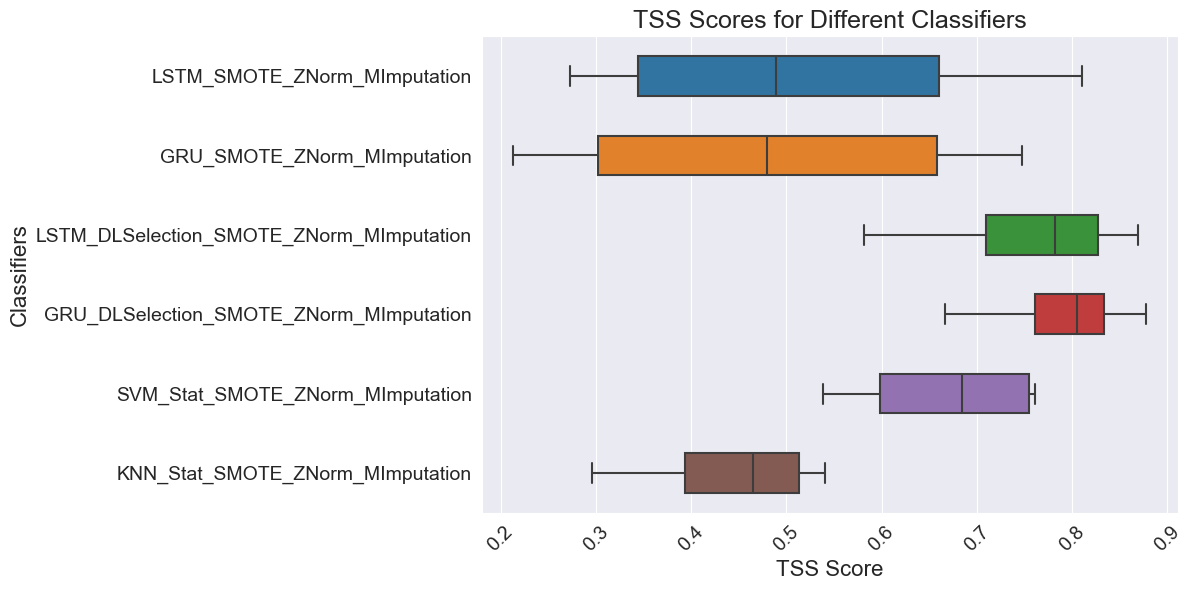

In [5]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths and classifier names
data_dir = "/Users/samskanderi/Documents/SWANSF/results/"
model_name = ['LSTM_SMOTE_ZNorm_MImputation', 'GRU_SMOTE_ZNorm_MImputation', 'LSTM_DLSelection_SMOTE_ZNorm_MImputation',
             'GRU_DLSelection_SMOTE_ZNorm_MImputation', 'SVM_Stat_SMOTE_ZNorm_MImputation', 'KNN_Stat_SMOTE_ZNorm_MImputation']

# Prepare a list to collect all TSS scores and model labels
tss_scores = []
models = []

# Function to generate file name based on model, sampling technique, and special naming conditions
def get_file_name(model):
    return f"{model}.pkl"
 

# Loop over each model and sampling technique
for model in model_name:
    file_name = get_file_name(model)
    file_path = data_dir + file_name
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            for entry in data:
                tss_scores.append(entry[6])  # Assuming the 7th element is the TSS score
                models.append(f"{model}")
    except FileNotFoundError as e:
        print(f"Error opening file {file_path}: {e}")

# Create DataFrame for plotting
df = pd.DataFrame({'Model': models, 'TSS': tss_scores})

# Plotting
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
sns.boxplot(y='Model', x='TSS', data=df, width=0.5)  # Swapped x and y axis

# Set explicit font sizes
title_fontsize = 18  # Increase base size by 25%
xlabel_fontsize = 16 # Increase base size by 50%
xticks_fontsize = 14  # Increase base size by 50%

plt.title('TSS Scores for Different Classifiers', fontsize=title_fontsize)
plt.xlabel('TSS Score', fontsize=xlabel_fontsize)
plt.ylabel('Classifiers', fontsize=xlabel_fontsize)
plt.xticks(rotation=45, fontsize=xticks_fontsize)
plt.yticks(fontsize=xticks_fontsize)


plt.tight_layout()
plt.savefig('classifiers_box.png')

plt.show()

## Correlation Analysis

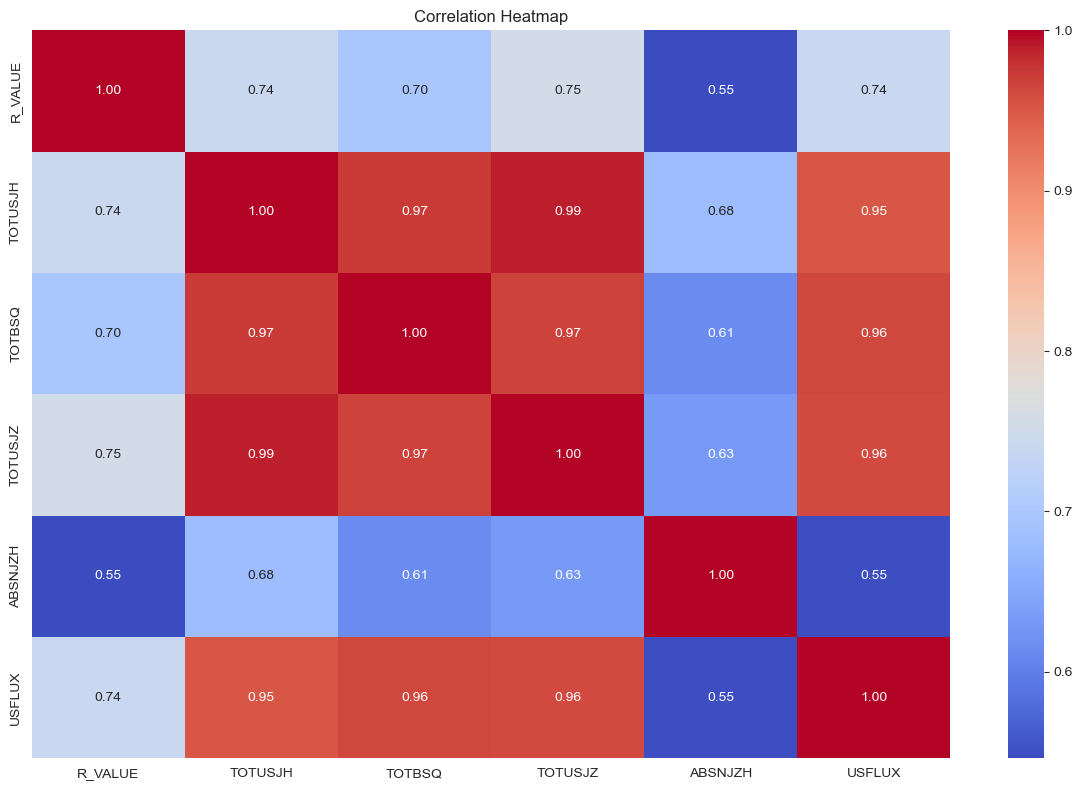

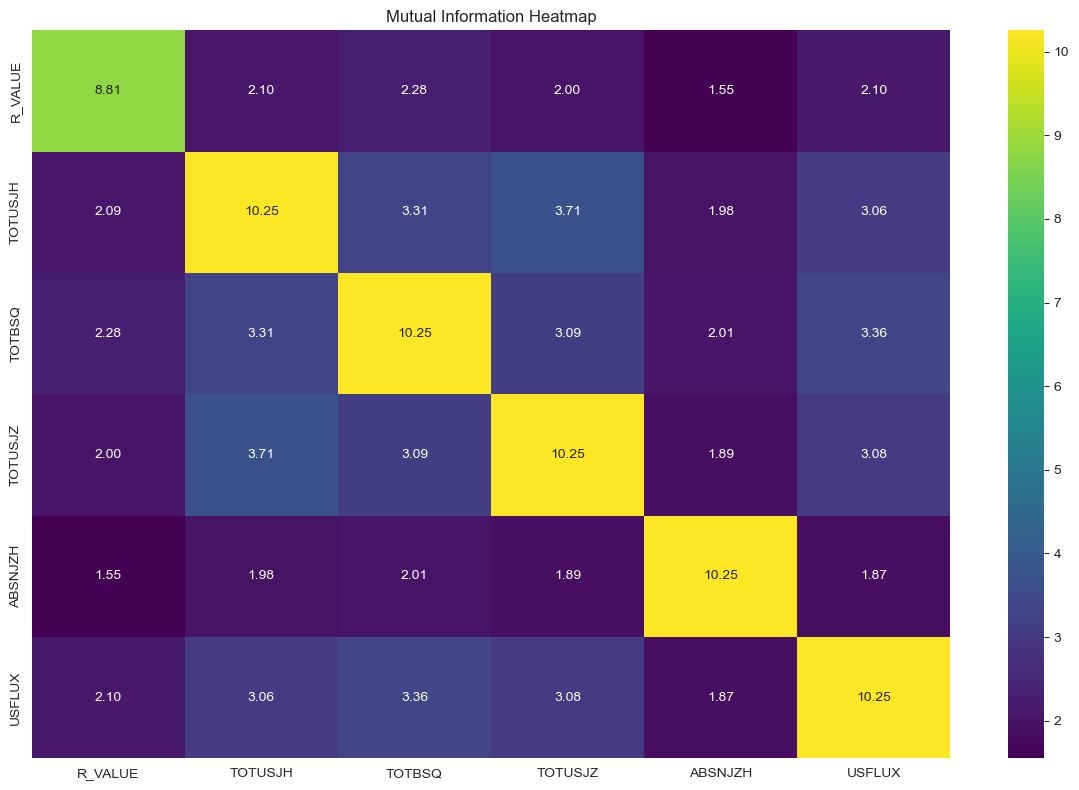

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pickle
from tqdm import tqdm


data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/6_Feature/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_DLSelection_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f))

    with open(data_dir + "Partition" + str(i+1) + "_Labels_DLSelection_SMOTE_ZNorm_MImputation" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))
        

def analyze_multivariate_data(partitions):
    """
    Analyze correlation and mutual information for multivariate time series data.

    Parameters:
    - partitions: list of 3D arrays, each with shape (num_samples, num_timestamps, num_attributes)
    
    Returns:
    - None
    """
    # Combine data from all partitions
    combined_data = np.concatenate(partitions, axis=0)  # Shape: (total_samples, num_timestamps, num_attributes)

    # Aggregate data across timestamps (e.g., compute mean)
    aggregated_data = np.mean(combined_data, axis=1)  # Shape: (total_samples, num_attributes)

    # Convert to DataFrame for easier manipulation
    num_attributes = aggregated_data.shape[1]
    feature_names = ['R_VALUE', 'TOTUSJH', 'TOTBSQ', 'TOTUSJZ', 'ABSNJZH', 'USFLUX']
    df = pd.DataFrame(aggregated_data, columns=feature_names)

    # Compute correlation matrix
    correlation_matrix = df.corr()

    # Compute mutual information matrix
    mutual_info_matrix = np.zeros((num_attributes, num_attributes))
    for i in range(num_attributes):
        mutual_info_matrix[i, :] = mutual_info_regression(aggregated_data, aggregated_data[:, i])

    # Plot Correlation Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=feature_names, yticklabels=feature_names)
    plt.title("Correlation Heatmap")
    
    plt.tight_layout()
    plt.savefig('correlation.png')

    plt.show()

    # Plot Mutual Information Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(mutual_info_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=feature_names, yticklabels=feature_names)
    plt.title("Mutual Information Heatmap")
    
    plt.tight_layout()
    plt.savefig('mutual_information.png')
    
    plt.show()

# Perform analysis
analyze_multivariate_data(data)

# Data Distribution Analysis

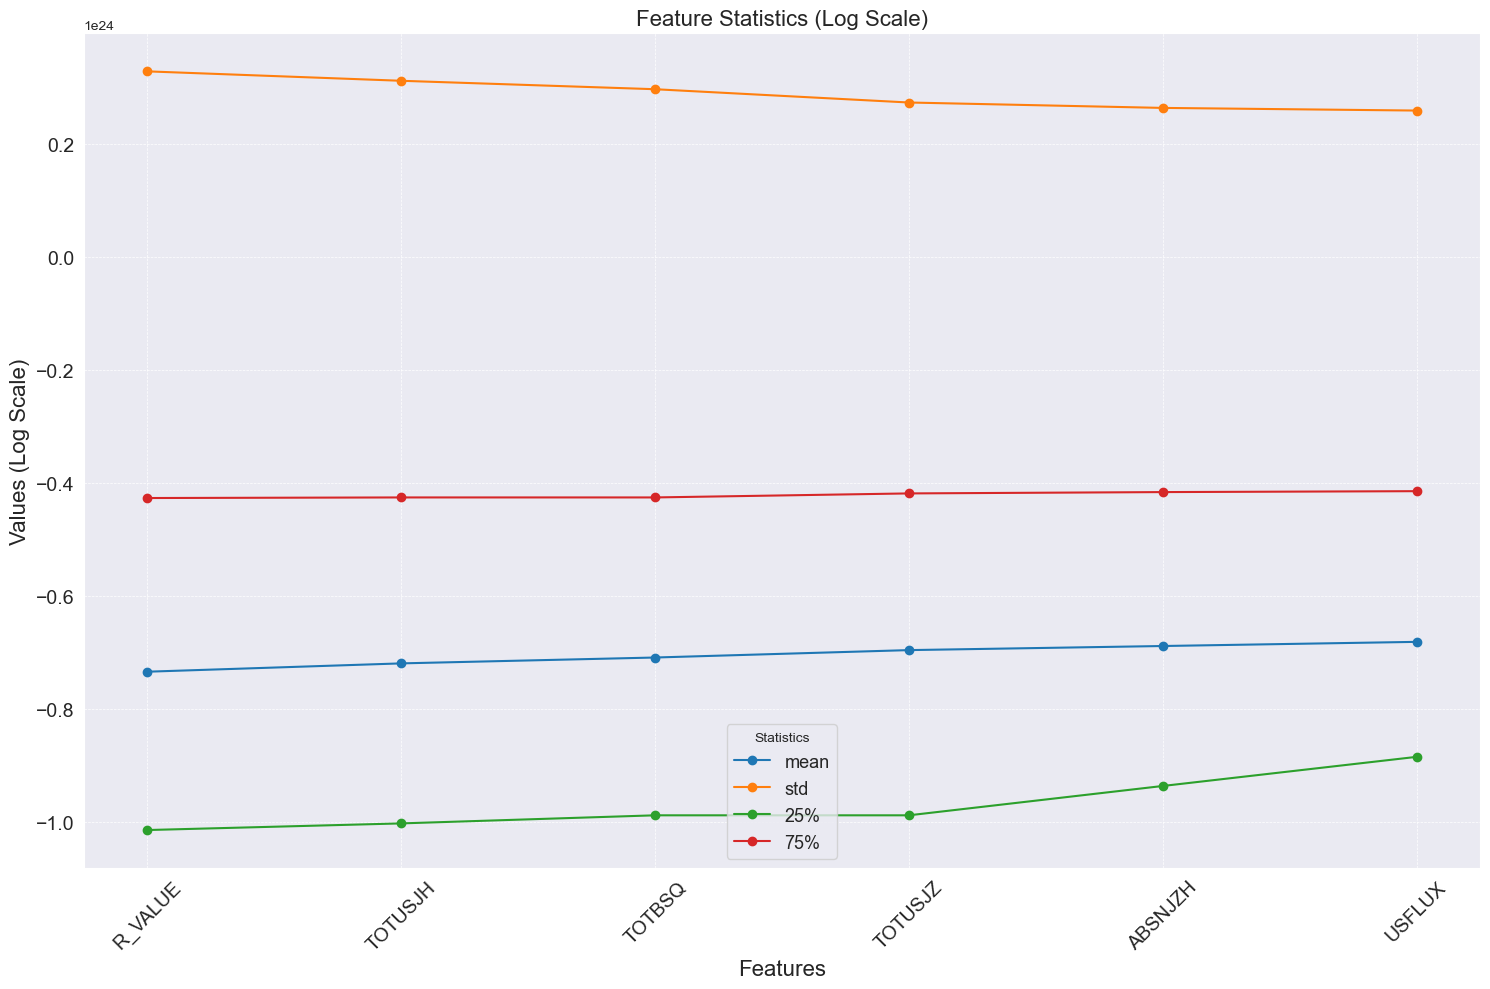

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pickle
from tqdm import tqdm


data_dir = "/Users/samskanderi/Documents/SWANSF/Pickle/3_Imputation/"

data = []
labels = []


num_partitions = 5

for i in range(0,num_partitions):
# Load the array with Pickle
    with open(data_dir + "Partition" + str(i+1) + "_MImputation" +".pkl", 'rb') as f:
        data.append(pickle.load(f)[:,:,[0,1,2,4,5,7]])

    with open(data_dir + "Partition" + str(i+1) + "_Labels_Raw" +".pkl", 'rb') as f:
        labels.append(pickle.load(f))


def plot_feature_statistics(partitions):
    """
    Plot the mean, std, 25th quartile, and 75th quartile for each feature
    on a logarithmic scale (10^x), excluding median, min, and max.

    Parameters:
    - partitions: list of 3D arrays, each with shape (num_samples, num_timestamps, num_attributes)
    
    Returns:
    - None
    """
    # Combine data from all partitions
    combined_data = np.concatenate(partitions, axis=0)  # Shape: (total_samples, num_timestamps, num_attributes)

    # Aggregate data across timestamps (e.g., compute mean for each sample)
    aggregated_data = np.mean(combined_data, axis=1)  # Shape: (total_samples, num_attributes)

    # Convert to DataFrame for easier manipulation
    num_attributes = aggregated_data.shape[1]
    feature_names = ['R_VALUE', 'TOTUSJH', 'TOTBSQ', 'TOTUSJZ', 'ABSNJZH', 'USFLUX']
    df = pd.DataFrame(aggregated_data, columns=feature_names)

    # Compute statistics for each feature
    statistics = df.describe(percentiles=[0.25, 0.75]).loc[["mean", "std", "25%", "75%"]]

    # Plot the statistics
    plt.figure(figsize=(15, 10))
    for stat in statistics.index:
        plt.plot(feature_names, statistics.loc[stat], label=stat, marker="o")

    # Apply logarithmic scale
    plt.title("Feature Statistics (Log Scale)", fontsize=16)
    plt.xlabel("Features", fontsize=16)
    plt.ylabel("Values (Log Scale)", fontsize=16)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title="Statistics", fontsize=13)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig('statistics.png')
    plt.show()


# Generate the plot
plot_feature_statistics(data)